In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Download NLTK resources (run only once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\vishw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("twitter_training.csv", header=None, encoding='utf-8')
df.columns = ['id', 'topic', 'sentiment', 'tweet']
df = df.dropna(subset=['tweet'])

In [4]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (73996, 4)


,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
# Step 2: Text Preprocessing
# =====================================================
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)               # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)             # Remove @mentions and hashtags
    text = re.sub(r"[^a-z\s]", "", text)              # Remove punctuation and digits
    text = re.sub(r"\s+", " ", text).strip()          # Remove extra spaces
    return text

df["clean_tweet"] = df["tweet"].apply(clean_text)

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\vishw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Tokenize
# Use regex-based tokenization to avoid NLTK 'punkt_tab' resource issues
df["tokens"] = df["clean_tweet"].apply(lambda x: [w for w in re.findall(r'\b\w+\b', x) if w not in stop_words])

print("Example tokens:", df["tokens"].iloc[0])

Example tokens: ['im', 'getting', 'borderlands', 'murder']


In [12]:
# Step 3: Word Frequency Distribution (Zipf’s Law)
# =====================================================
all_words = [word for tokens in df["tokens"] for word in tokens]
word_freq = Counter(all_words)
most_common = word_freq.most_common(50)

In [13]:
# Plot Zipf’s Law
ranks = np.arange(1, len(most_common) + 1)
freqs = [freq for _, freq in most_common]

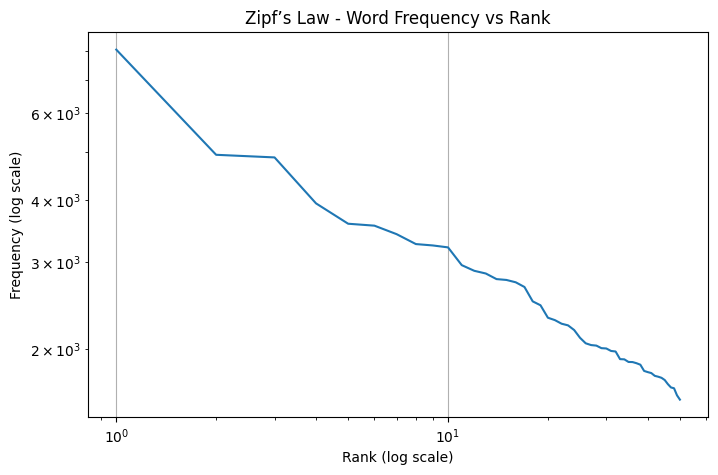

In [14]:
plt.figure(figsize=(8,5))
plt.loglog(ranks, freqs)
plt.title("Zipf’s Law - Word Frequency vs Rank")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.show()

In [15]:
# Step 4: Heaps’ Law (Vocabulary Growth)
# =====================================================
tokens = []
vocab = set()
num_tokens = []
num_vocab = []

for tweet in df["tokens"]:
    tokens.extend(tweet)
    vocab.update(tweet)
    num_tokens.append(len(tokens))
    num_vocab.append(len(vocab))


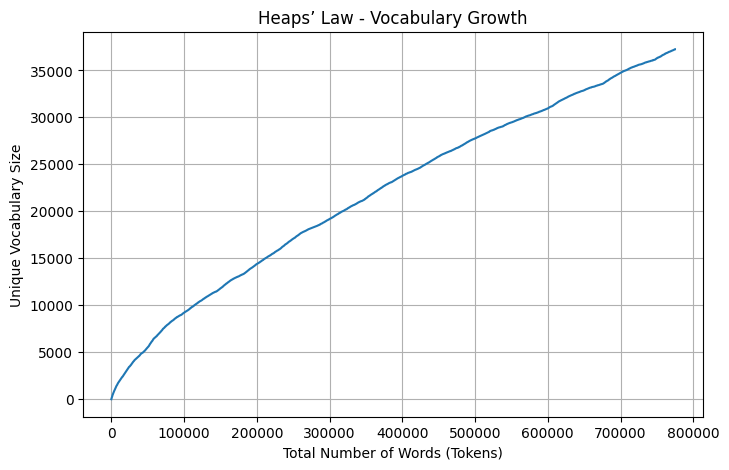

In [16]:
plt.figure(figsize=(8,5))
plt.plot(num_tokens, num_vocab)
plt.title("Heaps’ Law - Vocabulary Growth")
plt.xlabel("Total Number of Words (Tokens)")
plt.ylabel("Unique Vocabulary Size")
plt.grid(True)
plt.show()

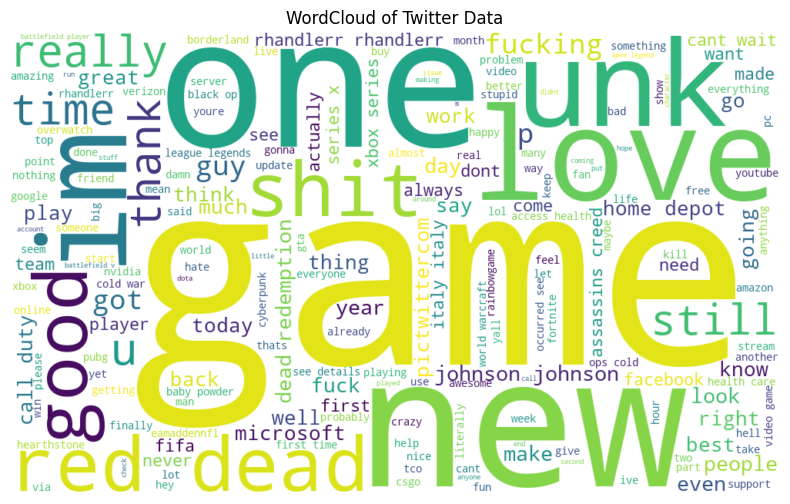

In [17]:
# Step 5: WordCloud Visualization
# =====================================================
text = " ".join(all_words)
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Twitter Data")
plt.show()


In [ ]:
# Step 6: Topic Modeling using LDA (Optimized for speed)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ✅ Limit dataset size (e.g., first 500 tweets only)
df_sample = df.head(500)

# Convert text to a bag-of-words representation
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df_sample["clean_tweet"])

# Build and fit LDA model (faster version)
lda = LatentDirichletAllocation(
    n_components=3,       # reduce topic count
    max_iter=5,           # fewer training iterations
    learning_method='online',  # faster optimization
    random_state=42
)
lda.fit(X)

print("✅ LDA model trained successfully!")

# Display top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

✅ LDA model trained successfully!

Topic #1:
im borderlands stream game love today playing just sorry good

Topic #2:
borderlands like dlc psycho new games time game play favorite

Topic #3:
borderlands fun fuck hey thank play streamer big try pretty


In [21]:
# Display topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"\nTopic {idx+1}:")
    print([terms[i] for i in topic.argsort()[-10:]])


Topic 1:
['good', 'sorry', 'just', 'playing', 'today', 'love', 'game', 'stream', 'borderlands', 'im']

Topic 2:
['favorite', 'play', 'game', 'time', 'games', 'new', 'psycho', 'dlc', 'like', 'borderlands']

Topic 3:
['pretty', 'try', 'big', 'streamer', 'play', 'thank', 'hey', 'fuck', 'fun', 'borderlands']


In [22]:
# Step 7: Insights
# =====================================================
print("\n✅ Zipf’s Law shows power-law distribution of word frequency.")
print("✅ Heaps’ Law confirms vocabulary growth with increasing tweet count.")
print("✅ LDA topic modeling extracts major discussion themes.")


✅ Zipf’s Law shows power-law distribution of word frequency.
✅ Heaps’ Law confirms vocabulary growth with increasing tweet count.
✅ LDA topic modeling extracts major discussion themes.
